

    Limitations of Algoritm:
            •   Database limited to c. 5000 items
            •   Limited and sometimes vague metadata
            •   Some metadata is not appropriate for the movie,
                ⁃ i.e. Movie has the keyword monster when it is unrelated.
                ⁃ Can provide occasional incorrect results

In [4]:
#Imports required libraries.
import pandas as pd
import matplotlib.pyplot as plt
import re


In [5]:
data = pd.read_csv('5000Movies.csv')
data = data[['budget', 'genres', 'keywords','original language', 'popularity', 
             'production company', 'revenue', 'runtime', 'title', 'vote average']]

#Familiarize ourselves with the dataset from kaggle.com
print(data.dtypes)
print(data.shape)

budget                  int64
genres                 object
keywords               object
original language      object
popularity            float64
production company     object
revenue                 int64
runtime               float64
title                  object
vote average          float64
dtype: object
(4803, 10)


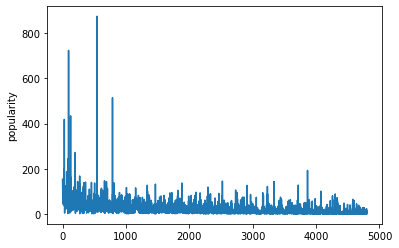

In [6]:
#Plot before normalizing, notice the challenging scale.
plt.plot(data['popularity'])
plt.ylabel('popularity')
plt.show()

Normalize function to take a pandas series of numbers and normalize it on a scale of 0 to 1, 
where 1 is the maximum of the series -- This function will allow us to easily factor in these numerical columns in
determining which movie to suggest.

In [7]:

def Normalize(df, column):
    df_max_scaled = df.copy()
    maxedColumn = column
    df_max_scaled[maxedColumn] = df_max_scaled[maxedColumn] / df_max_scaled[maxedColumn].max()
    return df_max_scaled[maxedColumn]

In [8]:
#Calls Normalize function on each of these three critical numerical columns
toNormalize = ['budget', 'popularity', 'revenue']
for i in toNormalize:
    data[i] = Normalize(data, i)


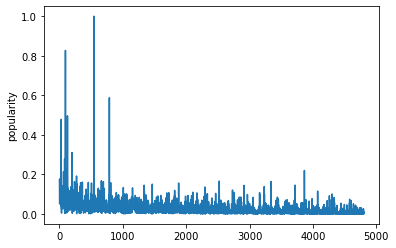

In [9]:
#Plot after normalizing
plt.plot(data['popularity'])
plt.ylabel('popularity')
plt.show()

In [10]:
#twoArray function -- populates and returns a two dimensional array, finalArray, with attributes for each movie.
#Keeps indexes consistent with the original indexing of the database for ease of reference later.
def twoArray(df, column):
    count = 0
    array = df[column]
    finalArray = []
    for i in array:
        count += 1
        if (type(i) == str):
            finalArray.append(re.split(",", i))
        else:
            finalArray.append([])
    return finalArray


#Utilizes twoArray func on 'genres', 'keywords', and 'production company' 
#Creates two series, one for title and one for popularity(already normalized), for ease of access later in the algo.
titleArr = data['title']
genresArr = twoArray(data, 'genres')
keywordsArr = twoArray(data, 'keywords')
prodArr = twoArray(data, 'production company')
popularityArr = data['popularity']

In [11]:
selectedMovie = input("What is your favorite movie?")

#Finds index of user selected movie
w = 0
for i in titleArr:
    if i == selectedMovie:
        selectedMovieIndex = w
    w += 1

recommendedMovie = ""

What is your favorite movie?Guardians of the Galaxy


In [12]:
#Rates every movie in dataset in relation to user selected movie
#Does so on the basis of categorical metadata provided by dataset
#Calculates and returns a ratio of what each of the above metadata has in common with the user selected movie.


def ratingEachMovie(array):
    index = 0
    returnArr = []
    for list in array:
        count = 0
        common = 0
        for item in list:
            for selectedItem in array[selectedMovieIndex]:
                if (item == selectedItem) & (item != ""):
                    common += 1
            if(item != ""):
                count += 1
        if(count != 0):
            returnArr.append(common / count)
        else:
            returnArr.append(0)
    return returnArr


#Creates and "Caches" a data frame using the ratingEachMovie function on three categorical columns of metadata.
cachedDFs = pd.DataFrame({'cachedGenres': ratingEachMovie(genresArr),
                    'cachedKeywords': ratingEachMovie(keywordsArr),
                  'cachedProd': ratingEachMovie(prodArr)})

cachedDFs.to_csv('cache.csv', index=False)

#Immediately reads from the temporary "cache". 
#Time save for the calculations to come
#The other option is calling 'ratingEachMovie' threetimes per calculation over 5000 rows of data.
cache = pd.read_csv('cache.csv')

In [13]:
#Creates and Populates an array to hold each of the final scores(0-1, 1 being most similar)
#Formula weights Genres and Production Company as half important as keywords.
#This choice was made to put an emphasis on keywords as they are more unique, 
#whereas similar genres are shared by sometimes unrelated movies.
#Furthermore, if production companies hold much weight, 
#all recommended movies will be by the same production company as the selected movie which I decided I did not want.
#Also, I divided popularity by 2 because I wanted to factor in popularity, however, 
#I did not want it to be a leading factor.
#The way in which I created a formula in just one line allows me to easily modify this algoritm as needed
#through trial and error.

#Alternative solution would have been to implement a 'term frequency-inverse document frequency' method
#This would have allowed us to weigh our metadata according to how often it appears.
#I chose to not use this method.
#In a future experiment I would love to utilize this method and compare results
z = 0
scoreArr = []
for i in titleArr:
    scoreArr.append(((((cache['cachedGenres'][z] * .5) + cache['cachedKeywords'][z] + 
                       cache['cachedProd'][z] * .5) + (popularityArr[z] * .5)) / 2.5))
    z += 1

In [14]:
#Creates a CSV for my purposes allowing me to ensure the algorithm works as expected,
#This CSV will also allow for easy display of the recommended movies to the user.

testCSV = pd.DataFrame({'Title': titleArr, 'Score': scoreArr,'cachedGenres': genresArr,
                    'cachedKeywords': keywordsArr,
                  'cachedProd': prodArr, 'genresScore': ratingEachMovie(genresArr),
                    'keywordsScore': ratingEachMovie(keywordsArr),
                  'prodScore': ratingEachMovie(prodArr),
                        'popularity': popularityArr})
testCSV.to_csv('Test.csv', index=False)

#ScoreDF is simply the sorted version of testCSV. It is sorted in descending order by the score value
#Note: Score Value provided by formula above.
scoreDF = pd.read_csv('Test.csv')

scoreDF = scoreDF.sort_values(by='Score', ascending=False)

#Displays top 10 recommended movies, including the movie selected.
print(scoreDF.head(10))

                                    Title     Score  \
94                Guardians of the Galaxy  0.909892   
182                               Ant-Man  0.656003   
79                             Iron Man 2  0.589085   
85    Captain America: The Winter Soldier  0.549831   
3051                            MacGruber  0.536540   
68                               Iron Man  0.527576   
31                             Iron Man 3  0.517744   
126                  Thor: The Dark World  0.516061   
7                 Avengers: Age of Ultron  0.497339   
16                           The Avengers  0.492995   

                                           cachedGenres  \
94    ['Action', 'Science Fiction', 'Adventure', '',...   
182   ['Science Fiction', 'Action', 'Adventure', '',...   
79    ['Adventure', 'Action', 'Science Fiction', '',...   
85    ['Action', 'Adventure', 'Science Fiction', '',...   
3051      ['Action', 'Adventure', 'Comedy', '', '', '']   
68    ['Action', 'Science Fiction', 'Adv